<a href="https://colab.research.google.com/github/lgvaz/faststyle/blob/master/examples/simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Mar 17 19:25:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:01:00.0  On |                  N/A |
| 22%   58C    P2    35W / 151W |   1447MiB /  8118MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!pip install -q git+git://github.com/fastai/fastcore.git
!pip install -q git+git://github.com/fastai/fastai2.git
!pip install -q git+git://github.com/lgvaz/faststyle.git

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from faststyle import *

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = Path('/content/gdrive/My Drive/')
# save_dir = root_dir/'dl/faststyle'; save_dir.mkdir(exist_ok=True, parents=True)
save_dir = Path('.')

In [3]:
source = untar_data(URLs.COCO_SAMPLE)

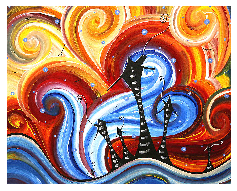

In [4]:
# Fix styles for colab
style_dir = Path('styles')
style_fns = L('village.jpg')
style_fns = style_fns.map(lambda o: style_dir/o)
show_images([PILImage.create(fn) for fn in style_fns])

In [5]:
dblock = DataBlock(style_blocks, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(1024)],
                   batch_tfms=[*aug_transforms(), NormalizeX.from_stats(*coco_stats)])

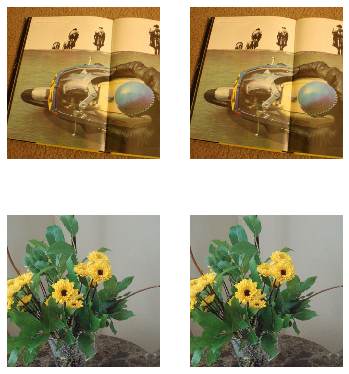

In [6]:
dls = dblock.dataloaders(source, bs=2)
dls.show_batch(max_n=3)

In [7]:
get_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [8]:
m = TransformerNet()
cbs = [SaveModelCallback()]
loss_func = FastStyleLoss(stl_w=3e5, tv_w=300)
learn = style_learner(dls, m, get_feats, style_fns, loss_func=loss_func, cbs=cbs)

In [0]:
learn.path = save_dir

In [0]:
# learn.lr_find()

In [0]:
learn.fit_one_cycle(1, 1e-3, pct_start=.9)

epoch,train_loss,valid_loss,stl,cnt,tv,time


In [0]:
learn.recorder.plot_loss()

In [0]:
learn.show_results()

In [0]:
learn.save('tn-village-1024_1')

In [0]:
learn.fit_one_cycle(1, 1e-3, pct_start=.15)

In [0]:
learn.save('tn-village_1024_2')